# Neural Network Classification (Binary)

## Data

In [106]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

len(X), len(y)


(1000, 1000)

In [107]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 samples of y:\n{y[:5]}")


First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
[1 1 1 1 0]


In [108]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})

circles.head(10)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


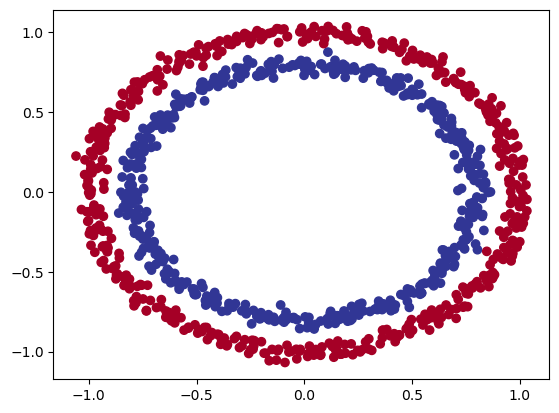

In [109]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)


In [110]:
X.shape, y.shape


((1000, 2), (1000,))

In [111]:
X


array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [112]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and for y: {y_sample}")
print(f"Shape for one sample of X: {X_sample.shape} and for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and for y: 1
Shape for one sample of X: (2,) and for y: ()


### Turn data into Tensors

In [113]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [114]:
X[:5], y[:5]


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [115]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X_train), len(X_test), len(y_train), len(y_test)


(800, 200, 800, 200)

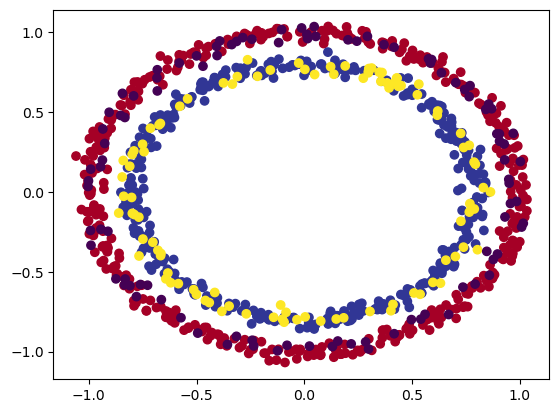

In [116]:
plt.scatter(x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu)
plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c=y_test)


## Create Model

In [117]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"


In [118]:
LAYERS = 3
FEATURES = 30


class CircleModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        layers = []
        for l in range(LAYERS):
            layers.append(nn.Linear(FEATURES, FEATURES))
            layers.append(nn.ReLU())

        self.linear_layers = nn.Sequential(
            nn.Linear(2, FEATURES), *layers, nn.Linear(FEATURES, 1)
        )

    def forward(self, x):
        return self.linear_layers(x)


model = CircleModel().to(device)
model


CircleModel(
  (linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): ReLU()
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): ReLU()
    (5): Linear(in_features=30, out_features=30, bias=True)
    (6): ReLU()
    (7): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [119]:
model.eval()
with torch.inference_mode():
    untrained_preds = model(X_test.to(device))

print(f"Predictions: Length: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Samples: Length: {len(X_test)}, Shape: {X_test.shape}")
print(f"First 10 preds: {untrained_preds[:10]}")
print(f"First 10 labels: {y_test[:10]}")


Predictions: Length: 200, Shape: torch.Size([200, 1])
Samples: Length: 200, Shape: torch.Size([200, 2])
First 10 preds: tensor([[-0.1394],
        [-0.1219],
        [-0.1427],
        [-0.1353],
        [-0.1013],
        [-0.0965],
        [-0.0985],
        [-0.0950],
        [-0.1437],
        [-0.1203]], device='cuda:0')
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Loss function and Optimizer

In [120]:
loss_fn = nn.BCEWithLogitsLoss()  # Includes the sigmoid activation function
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


In [121]:
# Calculate accuracy


def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100


## Training Loop

In [122]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_test.to(device))[:5]

y_logits


tensor([[-0.1394],
        [-0.1219],
        [-0.1427],
        [-0.1353],
        [-0.1013]], device='cuda:0')

In [123]:
y_pred_probs = torch.sigmoid(y_logits)

y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()


tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [124]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)

    # Expects raw logits, BCELoss would expect probabilities
    # For BCELoss, we'd need to pass torch.sigmoid(y_logits)

    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%"
        )


Epoch: 0 | Loss: 0.69524 | Acc: 50.00% | Test Loss: 0.69501 | Test Acc: 50.00%
Epoch: 10 | Loss: 0.69189 | Acc: 50.00% | Test Loss: 0.69238 | Test Acc: 50.00%
Epoch: 20 | Loss: 0.68924 | Acc: 64.12% | Test Loss: 0.69055 | Test Acc: 61.00%
Epoch: 30 | Loss: 0.68510 | Acc: 58.38% | Test Loss: 0.68808 | Test Acc: 51.50%
Epoch: 40 | Loss: 0.67814 | Acc: 55.62% | Test Loss: 0.68276 | Test Acc: 50.50%
Epoch: 50 | Loss: 0.66565 | Acc: 59.38% | Test Loss: 0.67156 | Test Acc: 57.50%
Epoch: 60 | Loss: 0.64250 | Acc: 72.50% | Test Loss: 0.65034 | Test Acc: 69.50%
Epoch: 70 | Loss: 0.59835 | Acc: 86.00% | Test Loss: 0.60922 | Test Acc: 86.00%
Epoch: 80 | Loss: 0.52024 | Acc: 99.50% | Test Loss: 0.53815 | Test Acc: 98.00%
Epoch: 90 | Loss: 0.40979 | Acc: 99.88% | Test Loss: 0.43661 | Test Acc: 99.50%


In [125]:
import requests
from pathlib import Path

if not Path("helper_functions.py").is_file():
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    )

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_decision_boundary, plot_predictions


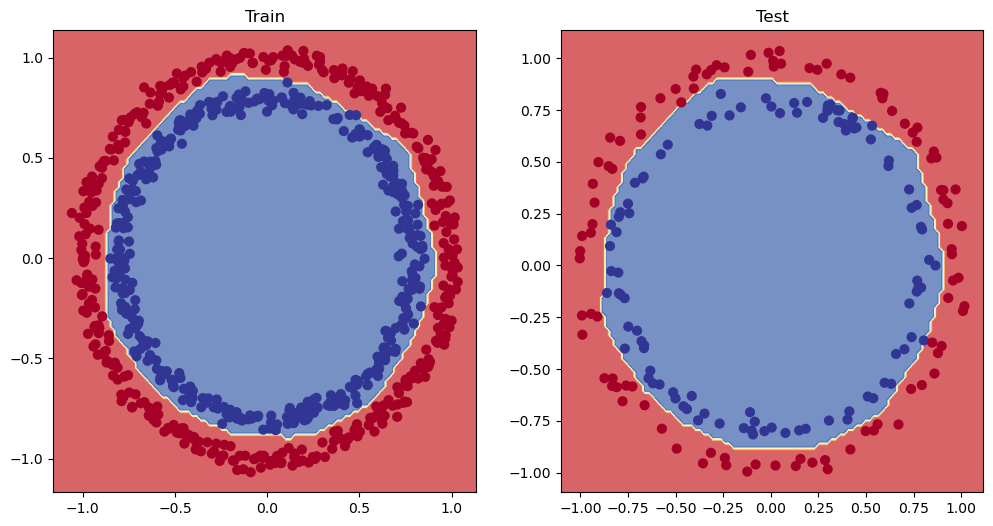

In [126]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)


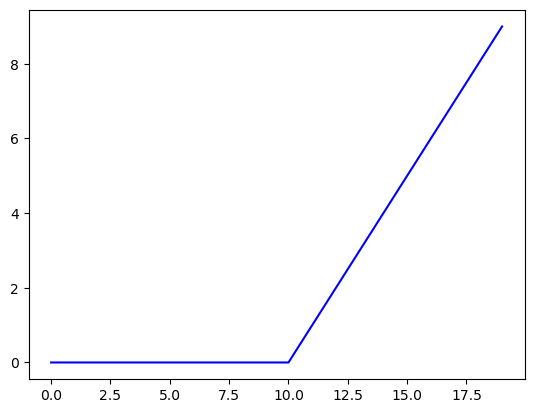

In [127]:
def myRelu(x: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.tensor(0), x)


A = torch.arange(-10, 10, 1.0)

plt.plot(myRelu(A), c="b")

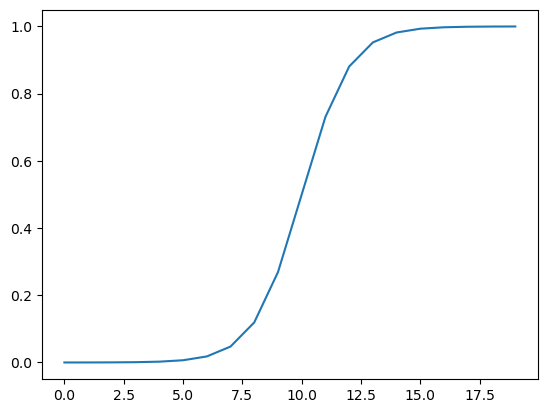

In [128]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))


plt.plot(sigmoid(A))

## Evaluate Model

## Save Model

# Multiclass Classification

## Data

tensor([3, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 3, 0, 2, 2, 2, 0, 0, 0, 1])


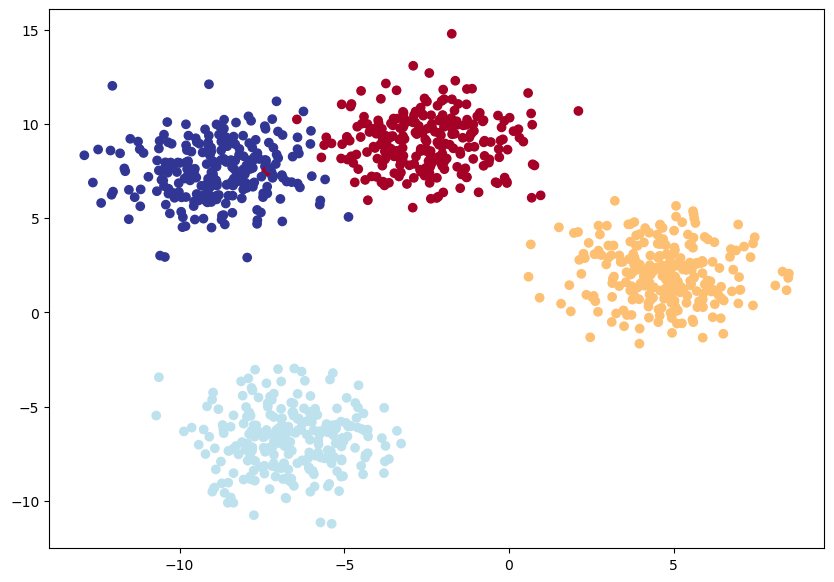

In [129]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Hyperparams

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

n_samples = 1000

X_blob, y_blob = make_blobs(
    n_samples=n_samples,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED,
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

print(y_blob[:20])

## Build Model

In [130]:
device = "cuda" if torch.cuda.is_available() else "cpu"


class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8) -> None:
        """Initializes multi-class

        Args:
            input_features (int): Number of input features
            output_features (int): Number of output features
            hidden_units (int): Number of hidden units between layers, default 8

        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


blob_model = BlobModel(input_features=2, output_features=4).to(device)

blob_model


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [131]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(blob_model.parameters(), lr=0.1)


In [132]:
blob_model.eval()
with torch.inference_mode():
    y_blob_logits = blob_model(X_blob_train.to(device))

y_blob_probs = torch.softmax(y_blob_logits, dim=1)

y_preds = torch.argmax(y_blob_probs, dim=1)
y_preds[:5]


tensor([1, 0, 0, 0, 0], device='cuda:0')

## Train the model

In [133]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    blob_model.train()

    y_logits = blob_model(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    blob_model.eval()
    with torch.inference_mode():
        test_logits = blob_model(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_preds)

    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f} | Acc {acc:.2f}% | Test Loss: {test_loss:5f} | Test Acc: {test_acc:2f}%"
        )


Epoch: 0 | Loss: 1.15883 | Acc 40.38% | Test Loss: 0.816673 | Test Acc: 68.500000%
Epoch: 10 | Loss: 0.03970 | Acc 98.75% | Test Loss: 0.019515 | Test Acc: 99.500000%
Epoch: 20 | Loss: 0.03161 | Acc 99.25% | Test Loss: 0.004417 | Test Acc: 100.000000%
Epoch: 30 | Loss: 0.02219 | Acc 99.12% | Test Loss: 0.006062 | Test Acc: 99.500000%
Epoch: 40 | Loss: 0.01999 | Acc 99.50% | Test Loss: 0.006904 | Test Acc: 99.500000%
Epoch: 50 | Loss: 0.01866 | Acc 99.50% | Test Loss: 0.008421 | Test Acc: 99.500000%
Epoch: 60 | Loss: 0.01779 | Acc 99.50% | Test Loss: 0.006935 | Test Acc: 100.000000%
Epoch: 70 | Loss: 0.01723 | Acc 99.38% | Test Loss: 0.005277 | Test Acc: 100.000000%
Epoch: 80 | Loss: 0.01661 | Acc 99.38% | Test Loss: 0.004420 | Test Acc: 100.000000%
Epoch: 90 | Loss: 0.01617 | Acc 99.38% | Test Loss: 0.004715 | Test Acc: 100.000000%


In [134]:
blob_model.eval()
with torch.inference_mode():
    y_blob_logits = blob_model(X_blob_test)

y_blob_probs = torch.softmax(y_blob_logits, dim=1)
y_blob_probs[:5]

tensor([[5.0355e-18, 1.0000e+00, 1.1408e-32, 4.4861e-27],
        [1.5166e-03, 7.7741e-12, 8.3371e-15, 9.9848e-01],
        [9.1545e-37, 2.1486e-39, 1.0000e+00, 5.7536e-21],
        [4.5693e-21, 1.0000e+00, 1.3574e-28, 7.4725e-27],
        [1.0000e+00, 1.8437e-08, 7.1395e-21, 4.5159e-10]], device='cuda:0')

In [135]:
# Turn the probabilities into class labels
y_blob_preds = torch.argmax(y_blob_probs, dim=1)
y_blob_preds[:5]

tensor([1, 3, 2, 1, 0], device='cuda:0')

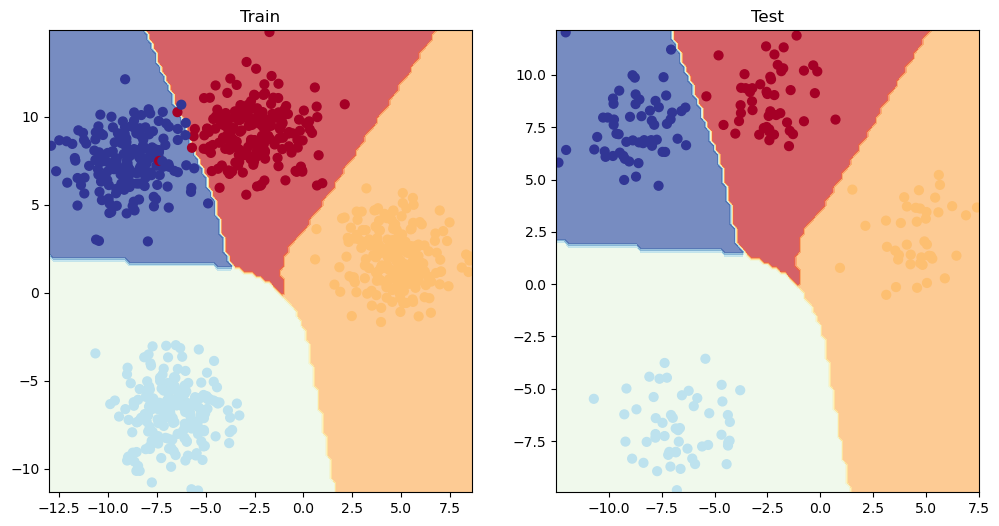

In [136]:
# Plot the decision boundary for training and test data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(blob_model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(blob_model, X_blob_test, y_blob_preds)


## Evaluate

In [145]:
# Evaluate the accuracy of the model using torchmetrics

import torchmetrics

accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=4).to(device)
f1 = torchmetrics.F1Score(task="multiclass", num_classes=4).to(device)
recall = torchmetrics.Recall(task="multiclass", num_classes=4).to(device)

print(
    f"Accuracy: {accuracy_fn(y_blob_preds, y_blob_test) * 100}%, F1: {f1(y_blob_preds, y_blob_test)} Recall: {recall(y_blob_preds, y_blob_test)}"
)

Accuracy: 100.0%, F1: 1.0 Recall: 1.0
